In [233]:
import json
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from collections import defaultdict
from sklearn.metrics import accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier

In [234]:
#Set some global plot defaults
sns.set(rc={"figure.figsize": (18, 6), 'legend.fontsize': 18}) # figsize and leg fontsize of seaborn plots
plt.rc('axes' , labelsize=18)                                  # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)                                  # fontsize of the tick labels
plt.rc('ytick', labelsize=18)                                  # fontsize of the tick labels
plt.rc('axes' , titlesize=18)                                  # fontsize of the plot title


In [235]:
#Loading json data file
logins = pd.read_json('/users/hp/desktop/Ds-springboard/take_home_challenge/ultimate_challenge/logins.json')
logins.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [236]:
logins.describe()

,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


Data consist of total of 93142 and unique values of 92265. There are some duplicates in this dataset

In [237]:
print(any(logins['login_time'].duplicated()))                   

True


In [238]:
g=logins[logins['login_time'].duplicated()]
g

,login_time
354,1970-01-02 10:59:52
434,1970-01-02 12:27:48
506,1970-01-02 15:08:27
524,1970-01-02 16:14:36
675,1970-01-02 22:03:36
684,1970-01-02 22:11:16
706,1970-01-02 22:30:34
727,1970-01-02 22:39:55
805,1970-01-03 00:19:04
1104,1970-01-03 05:10:59


In [239]:
# duplicates
k=logins[logins['login_time']=="1970-04-12 00:21:46"]
k

,login_time
91347,1970-04-12 00:21:46
91366,1970-04-12 00:21:46


In [240]:
#drop duplicates
df = logins.drop_duplicates(subset=['login_time'], keep='first')


In [241]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92265 entries, 0 to 93141
Data columns (total 1 columns):
login_time    92265 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 1.4 MB


In [242]:
df.set_index('login_time', inplace=True)
df['count'] = 1

/Users/hp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


# Part 1 - Exploratory Data Analysis

## 15 min logins distribution

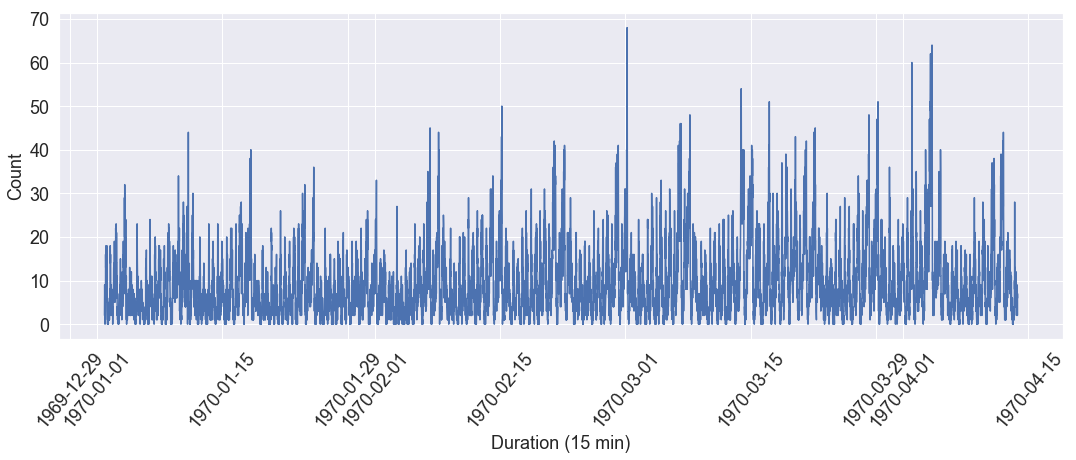

In [243]:
df_15T=df.resample('15T').sum().reset_index()
df_15T
x = df_15T['login_time']
y = df_15T['count']
plt.plot(x, y)
plt.xticks(rotation = 50)

plt.xlabel("Duration (15 min)")
plt.ylabel("Count")
plt.show()


There are spikes at certain period of time.

## Daily logins distribution

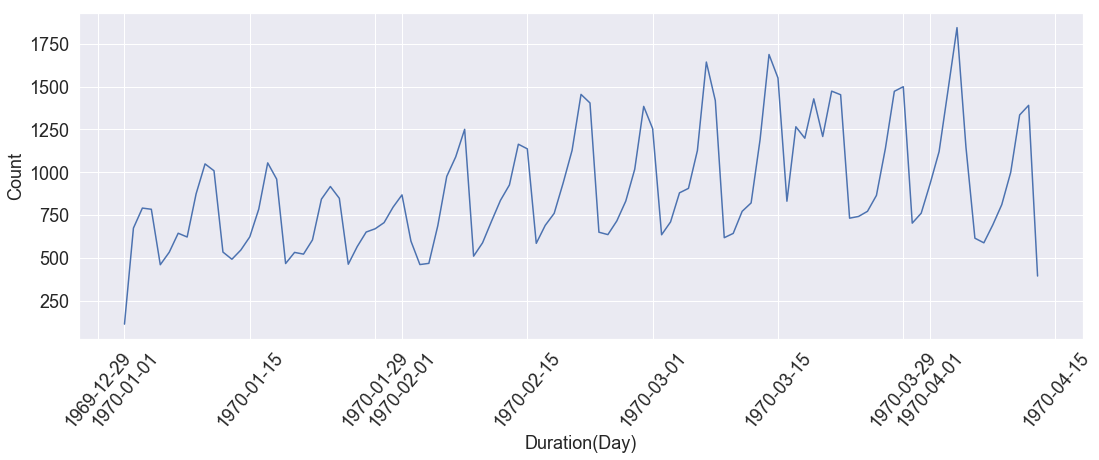

In [244]:
df_24H=df.resample('24H').sum().reset_index()
x = df_24H['login_time']
y = df_24H['count']
plt.plot(x, y)
plt.xticks(rotation = 50)

plt.xlabel("Duration(Day)")
plt.ylabel("Count")
plt.show()


## weekly logins distribution

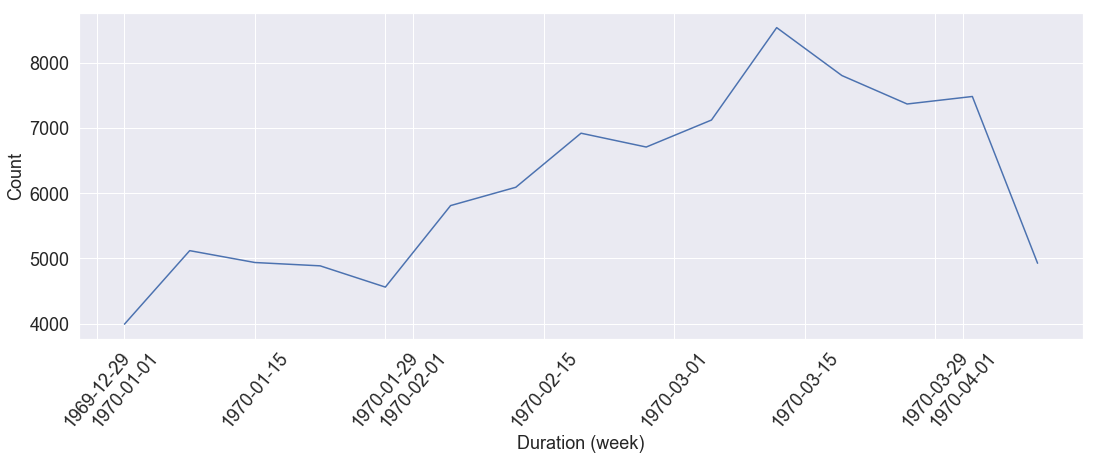

In [245]:
df_168H=df.resample('168H').sum().reset_index()
x = df_168H['login_time']
y = df_168H['count']
plt.plot(x, y)
plt.xticks(rotation = 50)

plt.xlabel("Duration (week)")
plt.ylabel("Count")
plt.show()


The login count is going in upward trend. It looks like March has the most logins for the month, followed by February, and then January.


In [246]:
# login counts per month
df_months = df_15T.groupby(df_15T['login_time'].dt.strftime('%B'))['count'].sum().sort_values()
df_months

login_time
April       13342
January     21103
February    24444
March       33376
Name: count, dtype: int64

## Monthly logins distribution

### January logins distribution

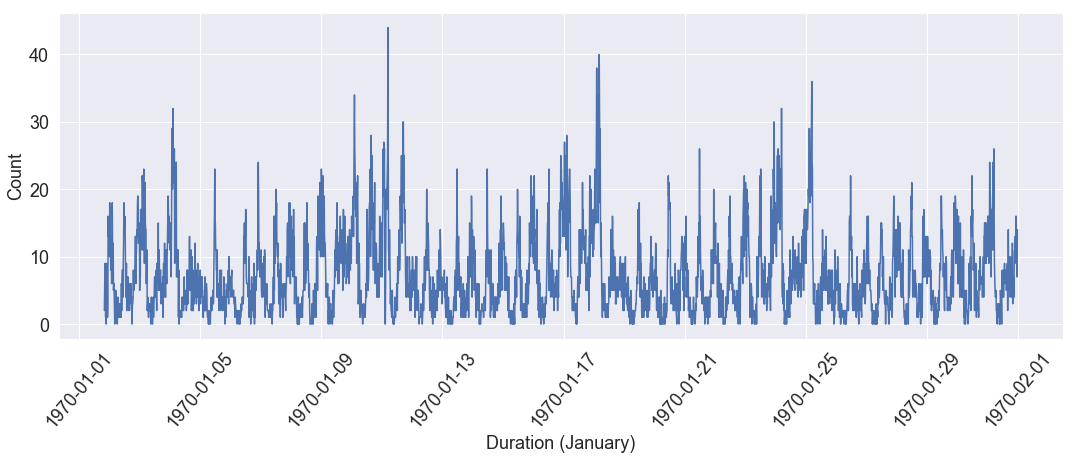

In [247]:
january = df_15T[(df_15T['login_time'] > '1970-01') & (df_15T['login_time'] < '1970-02')]
# Plot January Logins

x = january['login_time']
y = january['count']
plt.plot(x, y)
plt.xticks(rotation = 50)

plt.xlabel("Duration (January)")
plt.ylabel("Count")
plt.show()


### February logins Distribution

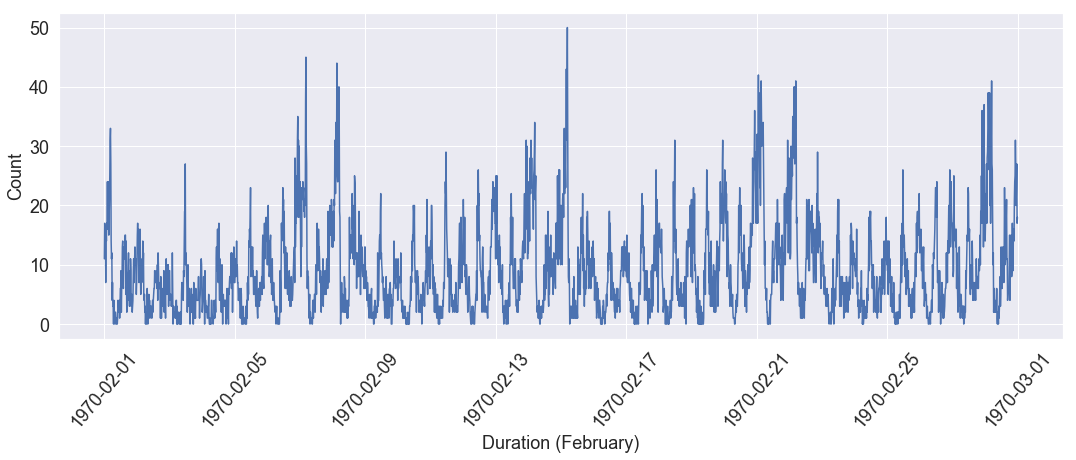

In [248]:
february = df_15T[(df_15T['login_time'] > '1970-02') & (df_15T['login_time'] < '1970-03')]
# Plot February Logins

x = february['login_time']
y = february['count']
plt.plot(x, y)
plt.xticks(rotation = 50)

plt.xlabel("Duration (February)")
plt.ylabel("Count")
plt.show()


### March logins distribution

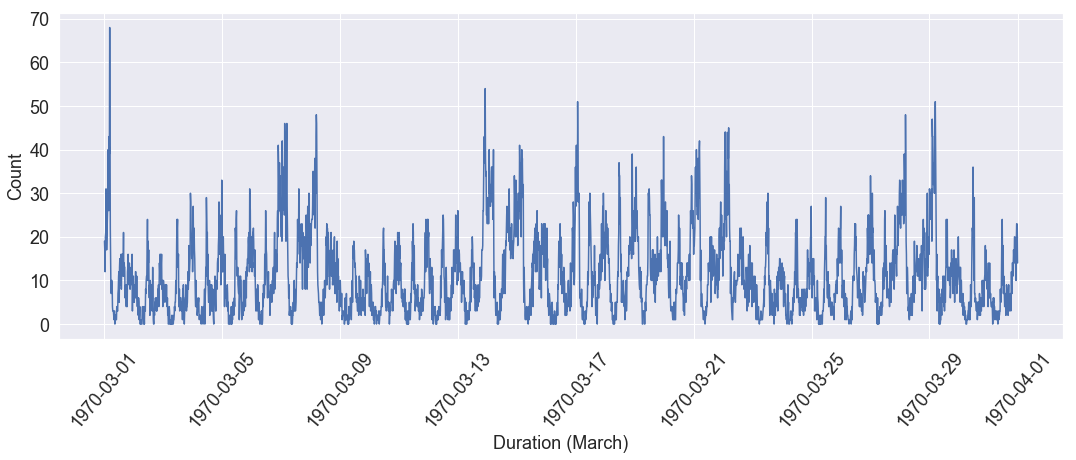

In [249]:
# Plot march Logins
march = df_15T[(df_15T['login_time'] > '1970-03') & (df_15T['login_time'] < '1970-04')]
# Plot March Logins

x = march['login_time']
y = march['count']
plt.plot(x, y)
plt.xticks(rotation = 50)

plt.xlabel("Duration (March)")
plt.ylabel("Count")
plt.show()


### April logins distribution


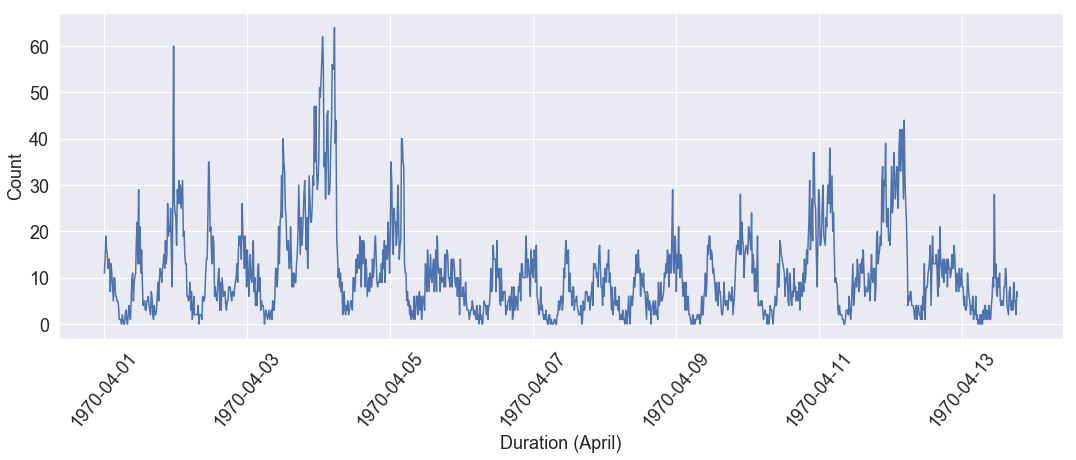

In [250]:
# Plot march Logins
april = df_15T[(df_15T['login_time'] > '1970-04') & (df_15T['login_time'] < '1970-05')]
# Plot March Logins

x = april['login_time']
y = april['count']
plt.plot(x, y)
plt.xticks(rotation = 50)

plt.xlabel("Duration (April)")
plt.ylabel("Count")
plt.show()


## Weekday logins distribution


In [251]:
# converting login time to year, month and day
df_15T['Year'] = df_15T['login_time'].dt.year
df_15T['Month'] = df_15T['login_time'].dt.month
df_15T['Day'] = df_15T['login_time'].dt.day
df_15T

,login_time,count,Year,Month,Day
0,1970-01-01 20:00:00,2,1970,1,1
1,1970-01-01 20:15:00,6,1970,1,1
2,1970-01-01 20:30:00,9,1970,1,1
3,1970-01-01 20:45:00,7,1970,1,1
4,1970-01-01 21:00:00,1,1970,1,1
5,1970-01-01 21:15:00,4,1970,1,1
6,1970-01-01 21:30:00,0,1970,1,1
7,1970-01-01 21:45:00,4,1970,1,1
8,1970-01-01 22:00:00,9,1970,1,1
9,1970-01-01 22:15:00,8,1970,1,1


In [252]:
#converting day to text
import datetime as dt

df_15T['weekday'] = df_15T[['login_time']].apply(lambda x: dt.datetime.strftime(x['login_time'], '%A'), axis=1)
df_15T

,login_time,count,Year,Month,Day,weekday
0,1970-01-01 20:00:00,2,1970,1,1,Thursday
1,1970-01-01 20:15:00,6,1970,1,1,Thursday
2,1970-01-01 20:30:00,9,1970,1,1,Thursday
3,1970-01-01 20:45:00,7,1970,1,1,Thursday
4,1970-01-01 21:00:00,1,1970,1,1,Thursday
5,1970-01-01 21:15:00,4,1970,1,1,Thursday
6,1970-01-01 21:30:00,0,1970,1,1,Thursday
7,1970-01-01 21:45:00,4,1970,1,1,Thursday
8,1970-01-01 22:00:00,9,1970,1,1,Thursday
9,1970-01-01 22:15:00,8,1970,1,1,Thursday


In [253]:
# weekday login counts
weekday_counts = df_15T.groupby('weekday').sum().sort_values('count').reset_index()
weekday_counts = weekday_counts[['weekday','count']]
weekday_counts

,weekday,count
0,Monday,8780
1,Tuesday,9194
2,Wednesday,10257
3,Thursday,11864
4,Friday,15061
5,Sunday,17963
6,Saturday,19146


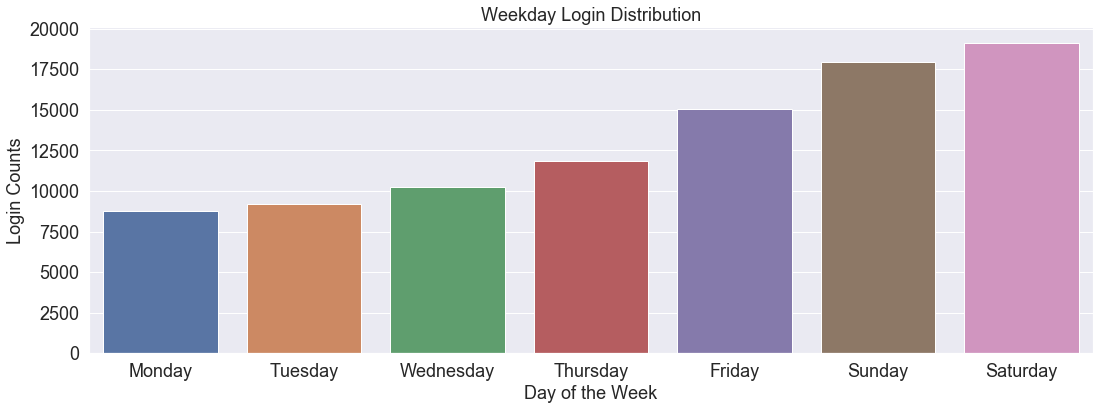

In [254]:
sns.barplot(x= 'weekday', y='count', data=weekday_counts, order=weekday_counts['weekday'])
plt.xlabel('Day of the Week')
plt.title('Weekday Login Distribution')
plt.ylabel('Login Counts')
plt.show()


Above plot shows the Saturday is the highest login count followed by Sunday and Friday. Least login count is on Monday. 

## hourly login distribution

In [255]:
df_15T['hour'] = df_15T['login_time'].dt.hour
df_15T
hour_counts = df_15T.groupby('hour').sum().sort_values('hour').reset_index()

hour_counts = hour_counts[['hour', 'count']]
hour_counts


,hour,count
0,0,5934
1,1,6220
2,2,5723
3,3,4762
4,4,4953
5,5,2904
6,6,1132
7,7,814
8,8,818
9,9,1522


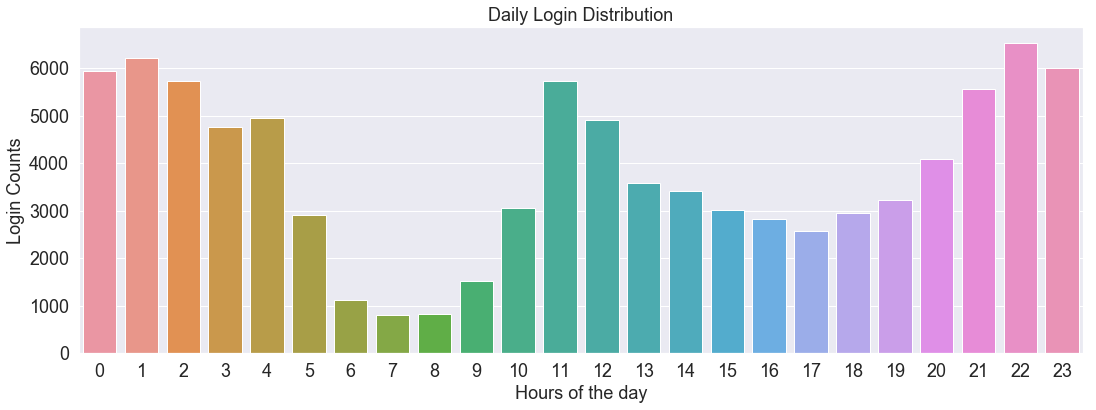

In [256]:
sns.barplot(x= 'hour', y='count', data=hour_counts, order=hour_counts['hour'])
plt.xlabel('Hours of the day')
plt.title('Daily Login Distribution')
plt.ylabel('Login Counts')
plt.show()


Above plot shows highest login distributions are during early morning, late night and after noon. 

# Part 2 - Experiment and metrics design¶


The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two-way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities by reimbursing all toll costs.

Question 1: What woud you choose as the key measure of success of this experiment in encouraging driver partners to server both cities, and why would you choose this metric?

Question 2: Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

a. How you will implement the experiment

b. What statistical test(s) you will conduct to verify the significance of the observation

c. How would you interpret the results and provide recommendations to the city operations team along with any caveats.

Answer 1:

For a single experiment, a measure of the ratio of activity of a driver in the other city. For example, assume driver A from Gotham drove 100 times. Only 5 of them were in Metropolis. Driver A's ratio is then 5%. Currently, drivers in both cities have high ratios towards their primary city. Ultimate would like to move these ratios towards 50% so that the drivers are closer to evenly distributed: driving in both cities. This metric would show the experiment working or not working reasonably well.


Answer 2:

One simple experiment that we can perform is to conduct an A/B Test. The control group would be users that do not use the toll bridge. And the test group would be users that do use the toll bridge. We'll have to keep track of the revenue gained from both sides and compare it against each other within a few months. Or if you want a more accurate reading, we can collect the data within a year's time.

A statistical test that we can use is applying a t-test, with a p-value of (0.5). Then we could run a two-tailed $z$-test comparing sample proportions (since that is what the ratio is). This would give us a $z$-score and associated $p$-value. A low $p$-value (say at $\alpha$=0.01) would potentially indicate a significant change in our experiment (good or bad). We could further calculate the confidence intervals for this to be able to strongly claim a statistical change in the experiment, if it exists.


Assuming our experiment does change, and in a positive direction, then we still have to be mindful of the results. We could see positive change, where more drivers are now in the city other than their primary. However, we have to estimate the amount of revenue that exact change has brought and compare it to the cost of the program (remember Ultimate is paying the tolls!). A positive experiment change coupled with negative revenue is perhaps not the ideal. We also mentioned that while the program can result in a statistical change in the experiment, it could lead to worse results. So the analysts need to be aware of this fact as well. Further, this ratio metric is time agnostic, ignoring weekdays, weekends, day or night. A further iteration of this analysis would also include this (by perhaps binning in time) to see if perhaps there are certain times when the program is being used more than others.




# Part 3 - Predictive Modeling¶


Ultimate     is     interested     in     predicting     rider     retention.    To    help    explore     this    question,    we    have  provided     a     sample    dataset     of     a     cohort    of    users    who     signed    up     for    an    Ultimate    account     in  January    2014.    The     data    was    pulled     several    months     later;    we     consider    a    user     retained     if     they  were     “active”     (i.e.     took    a     trip)     in     the     preceding    30    days.    We     would     like     you     to    use     this    data     set     to    help    understand    what     factors    are     the    best    predictors  for     retention,    and    offer     suggestions     to     operationalize     those     insights     to    help    Ultimate.    The    data     is     in     the    attached     file     ultimate_data_challenge.json.    See    below     for    a    detailed  description     of     the    dataset.     Please     include    any     code     you    wrote     for     the    analysis    and    delete     the  dataset    when     you    have     finished     with     the     challenge.


1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long-term frider retention (again, a few sentences will suffice).

Data Description:

    city: city this user signed up in
    phone: primary device for this user
    singup_date: date of account registration; in the form 'YYYYMMDD'
    last_trip_date: the last time this user completed a trip; in the form 'YYYYMMDD'
    avg_dist: the average distance in miles per trip taken in the first 30 days after signup
    avg_rating_by_driver: the rider's average rating over all of their trips
    avg_rating_of_driver: the rider's average rating of their drivers over all of their trips
    surge_pct: the percent of trips taken with surge multiplyer > 1
    avg_surge: The average surge multiplier over all of this users trips
    trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up
    ultimate_black_user:TRUE if the user took an Ultimate Black in their first 30 days. FALSE otherwise
    weekday_pct: the percent of the user's trip occurring during a weekday


In [257]:
# Import json and read data into dataframe
import json

file = open('/users/hp/desktop/Ds-springboard/take_home_challenge/ultimate_challenge/ultimate_data_challenge.json', 'r')
df_ultimate = pd.DataFrame(json.load(file))
file.close()


In [258]:
df_ultimate

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4
5,10.56,5.0,3.5,1.00,Winterfell,2014-06-06,iPhone,2014-01-09,0.0,2,True,100.0
6,3.95,4.0,NaN,1.00,Astapor,2014-01-25,Android,2014-01-24,0.0,1,False,100.0
7,2.04,5.0,5.0,1.00,Winterfell,2014-01-29,iPhone,2014-01-28,0.0,2,False,100.0
8,4.36,5.0,4.5,1.00,Winterfell,2014-02-01,Android,2014-01-21,0.0,2,False,100.0
9,2.37,5.0,NaN,1.00,Winterfell,2014-01-05,Android,2014-01-03,0.0,1,False,0.0


In [259]:
df_ultimate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [260]:
#Convert the time series to datetimes appropriately
df_ultimate.signup_date = pd.to_datetime(df_ultimate.signup_date)
df_ultimate.last_trip_date = pd.to_datetime(df_ultimate.last_trip_date)


In [261]:
df_ultimate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


In [262]:
# city value counts
df_ultimate['city'].value_counts()


Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64

In [263]:
#phone value counts
df_ultimate['phone'].value_counts()


iPhone     34582
Android    15022
Name: phone, dtype: int64

In [264]:
df_ultimate.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


## Exploratory Data Analysis

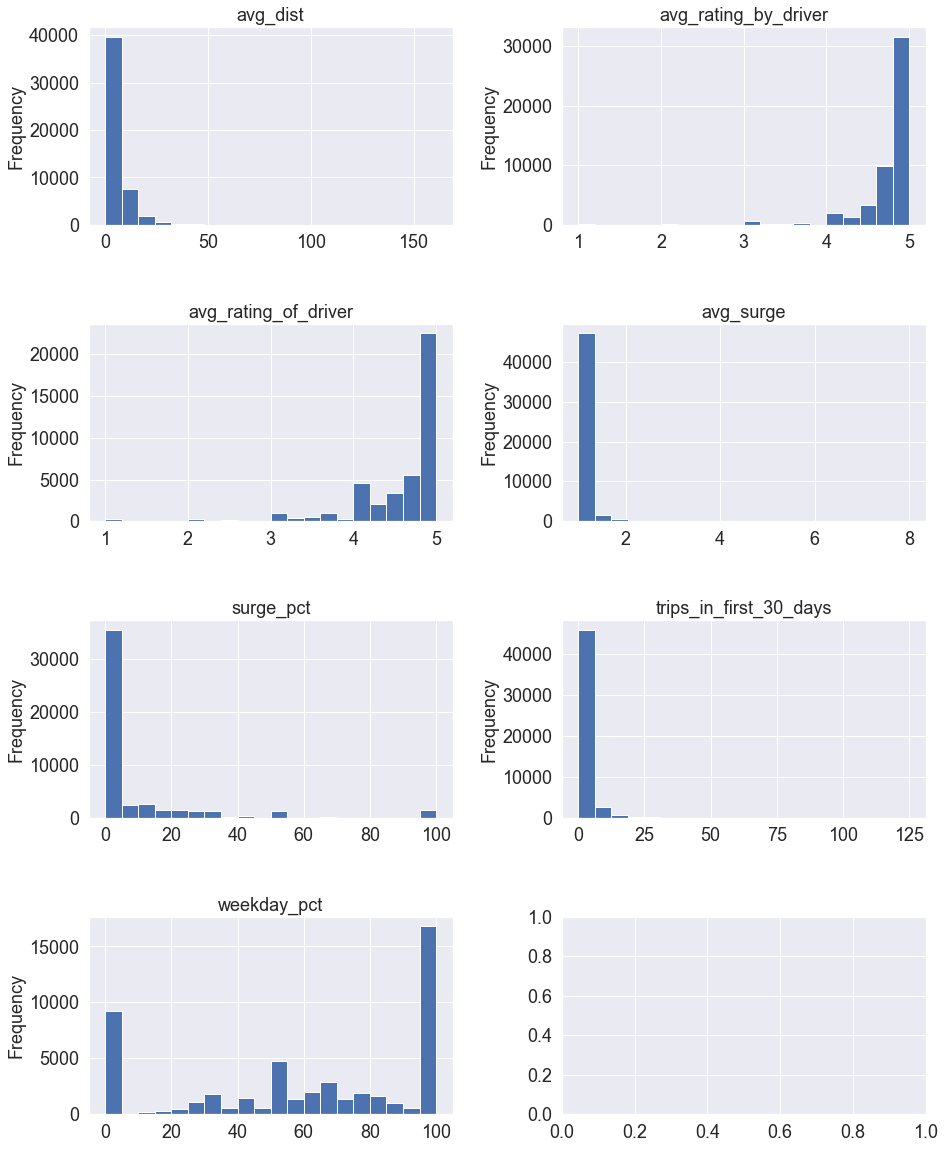

In [265]:
#Make subplotted figure
fig, axes = plt.subplots(4, 2, figsize=(15,20))

#Cycle through all relevant columns
i = 1
#for col in df_ultimate.select_dtypes(include=[np.float64, np.int64, np.bool]).columns:
for col in df_ultimate.select_dtypes(include=[np.float64, np.int64]).columns:
    plt.subplot(4, 2, i)
    #print(col)
    df_ultimate[col].plot.hist(title=col, logy=False, bins=20)
    i += 1

#Show
fig.subplots_adjust(hspace=0.5, wspace=0.3)    
plt.show()


Most of the above plots show heavily skewed distribution.

In [266]:
df_ultimate.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


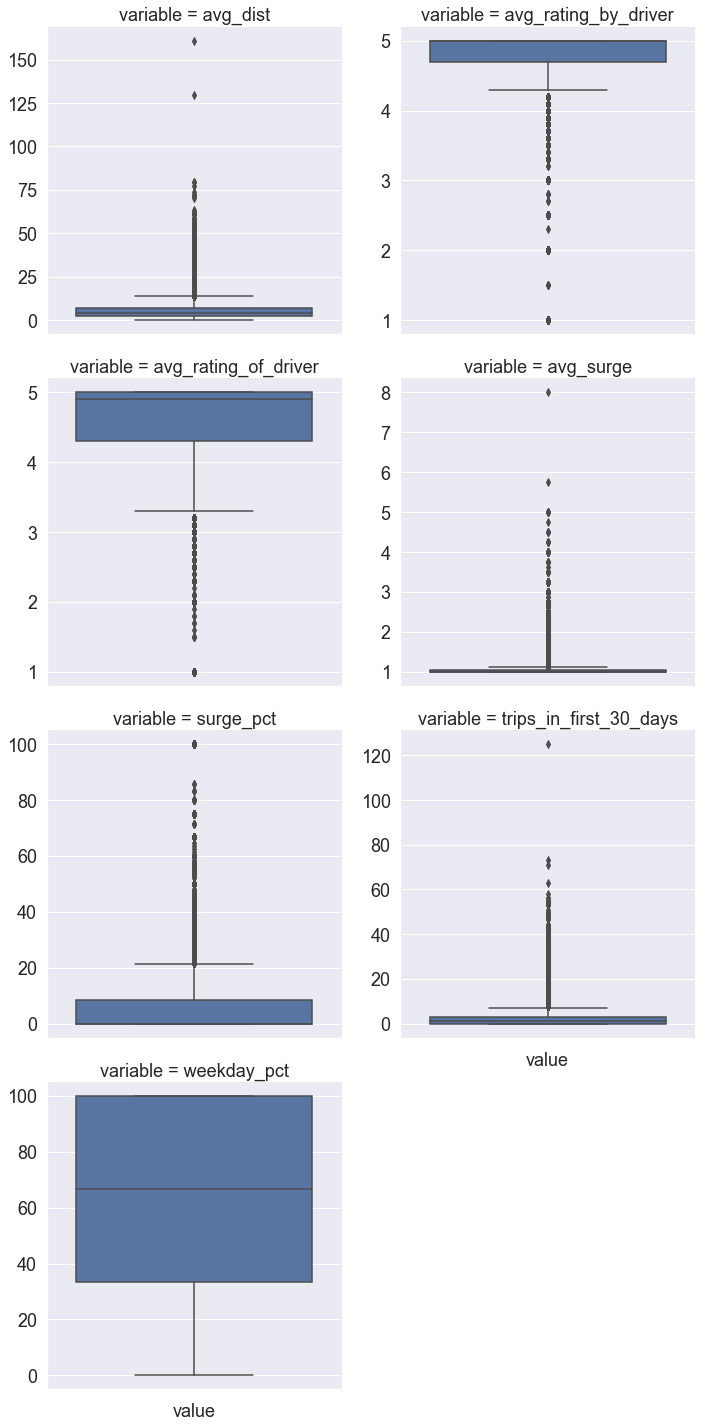

In [267]:
def boxplot(y, **kwargs):
    sns.boxplot(y=y)
    x=plt.xticks(rotation=90)
f = pd.melt(df_ultimate, value_vars=['avg_dist','avg_rating_by_driver','avg_rating_of_driver','avg_surge','surge_pct','trips_in_first_30_days','weekday_pct'])
g = sns.FacetGrid(f,  col="variable",col_wrap=2, sharex=False, sharey=False, height=5)
g = g.map(boxplot,"value")


In [268]:
# removing outliers
# Filter out rows with features that have values more than 3 standard deviations from the mean
df_ultimate = df_ultimate[np.abs(df_ultimate['avg_dist']-df_ultimate['avg_dist'].mean())<=(4*df_ultimate['avg_dist'].std())]
df_ultimate = df_ultimate[np.abs(df_ultimate['avg_rating_by_driver']-df_ultimate['avg_rating_by_driver'].mean())<=(4*df_ultimate['avg_rating_by_driver'].std())]
df_ultimate = df_ultimate[np.abs(df_ultimate['avg_rating_of_driver']-df_ultimate['avg_rating_of_driver'].mean())<=(4*df_ultimate['avg_rating_of_driver'].std())]
df_ultimate = df_ultimate[np.abs(df_ultimate['avg_surge']-df_ultimate['avg_surge'].mean())<=(4*df_ultimate['avg_surge'].std())]
df_ultimate = df_ultimate[np.abs(df_ultimate['surge_pct']-df_ultimate['surge_pct'].mean())<=(4*df_ultimate['surge_pct'].std())]
df_ultimate = df_ultimate[np.abs(df_ultimate['trips_in_first_30_days']-df_ultimate['trips_in_first_30_days'].mean())<=(4*df_ultimate['trips_in_first_30_days'].std())]
df_ultimate.reset_index(drop=True, inplace=True)


In [269]:
#missing value counts in each of these columns
total = df_ultimate.isnull().sum().sort_values(ascending=False)
percent = (df_ultimate.isnull().sum()/df_ultimate.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data = missing_data[missing_data['Total']>0]
missing_data

,Total,Percent
phone,281,0.007128


In [270]:
df_ultimate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39422 entries, 0 to 39421
Data columns (total 12 columns):
avg_dist                  39422 non-null float64
avg_rating_by_driver      39422 non-null float64
avg_rating_of_driver      39422 non-null float64
avg_surge                 39422 non-null float64
city                      39422 non-null object
last_trip_date            39422 non-null datetime64[ns]
phone                     39141 non-null object
signup_date               39422 non-null datetime64[ns]
surge_pct                 39422 non-null float64
trips_in_first_30_days    39422 non-null int64
ultimate_black_user       39422 non-null bool
weekday_pct               39422 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 3.3+ MB


In [271]:
#dropping null values
df_ultimate.dropna(inplace=True)
df_ultimate.reset_index(drop=True, inplace=True)

df_ultimate.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39141 entries, 0 to 39140
Data columns (total 12 columns):
avg_dist                  39141 non-null float64
avg_rating_by_driver      39141 non-null float64
avg_rating_of_driver      39141 non-null float64
avg_surge                 39141 non-null float64
city                      39141 non-null object
last_trip_date            39141 non-null datetime64[ns]
phone                     39141 non-null object
signup_date               39141 non-null datetime64[ns]
surge_pct                 39141 non-null float64
trips_in_first_30_days    39141 non-null int64
ultimate_black_user       39141 non-null bool
weekday_pct               39141 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 3.3+ MB


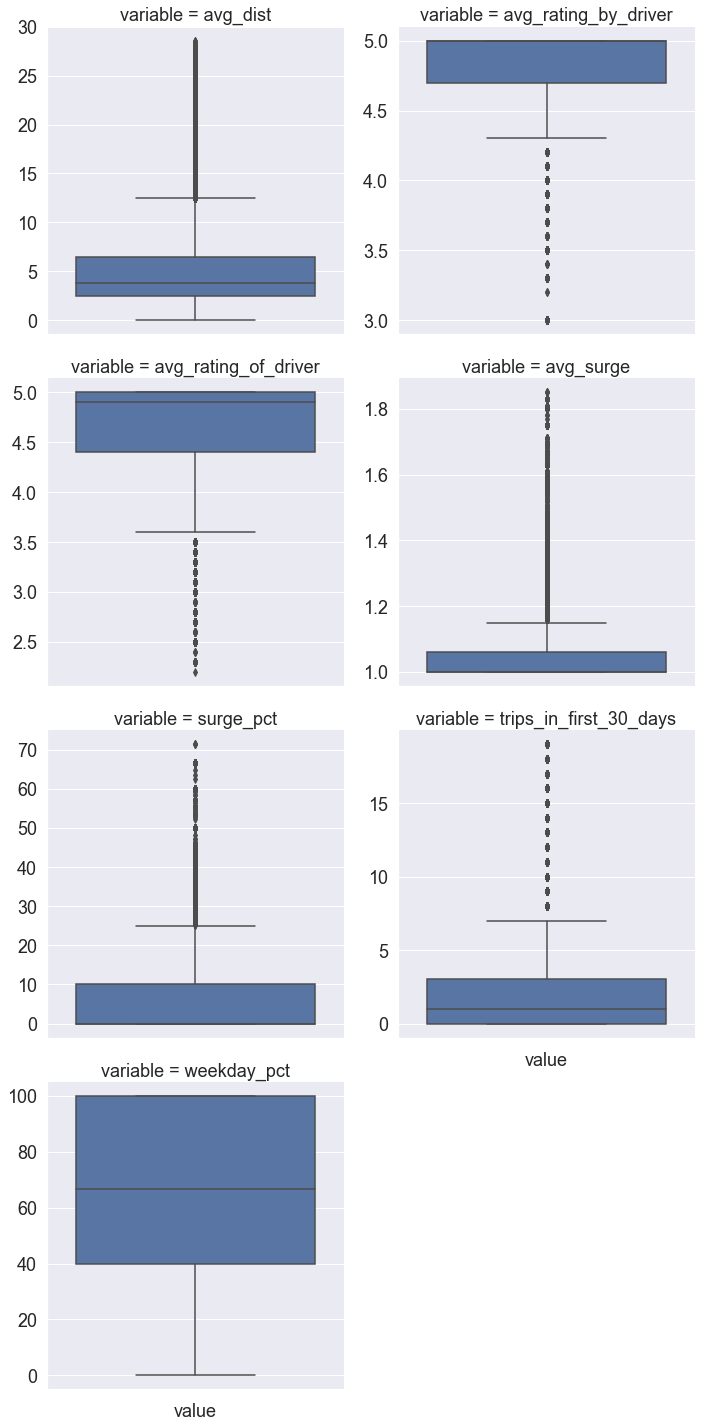

In [272]:
# numerical count plots
def boxplot(y, **kwargs):
    sns.boxplot(y=y)
    x=plt.xticks(rotation=90)
f = pd.melt(df_ultimate, value_vars=['avg_dist','avg_rating_by_driver','avg_rating_of_driver','avg_surge','surge_pct','trips_in_first_30_days','weekday_pct'])
g = sns.FacetGrid(f,  col="variable",col_wrap=2, sharex=False, sharey=False, height=5)
g = g.map(boxplot,"value")


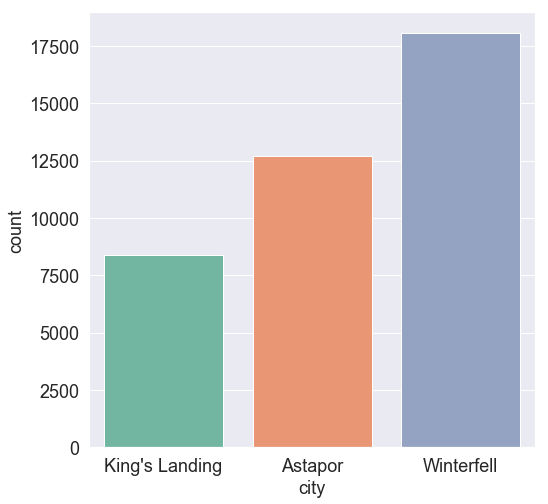

In [273]:
# categorical count plots
plt.figure(figsize=(8,8))

g =sns.countplot(x="city", data=df_ultimate, palette="Set2")


As we noted in exploratory analysis, winterfell city has highest number of signups

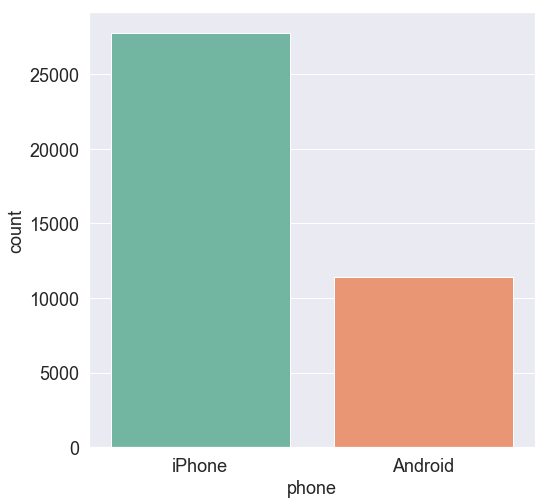

In [274]:
plt.figure(figsize=(8,8))

g =sns.countplot(x="phone", data=df_ultimate, palette="Set2")


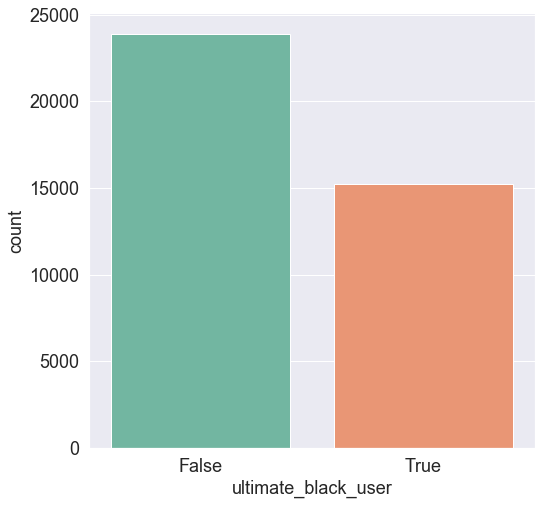

In [275]:
plt.figure(figsize=(8,8))

g =sns.countplot(x="ultimate_black_user", data=df_ultimate, palette="Set2")


In [276]:
# Show the correlation matrix
corr_matrix = df_ultimate.corr()
corr_matrix


,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
avg_dist,1.000000,0.102821,0.052020,-0.121532,-0.140245,-0.156076,0.031983,0.110478
avg_rating_by_driver,0.102821,1.000000,0.123143,-0.020114,-0.012904,-0.079707,-0.003123,0.027435
avg_rating_of_driver,0.052020,0.123143,1.000000,-0.036725,-0.021024,-0.062388,-0.014307,0.008458
avg_surge,-0.121532,-0.020114,-0.036725,1.000000,0.848424,0.097326,-0.029075,-0.109426
surge_pct,-0.140245,-0.012904,-0.021024,0.848424,1.000000,0.096407,-0.048822,-0.123733
trips_in_first_30_days,-0.156076,-0.079707,-0.062388,0.097326,0.096407,1.000000,0.095351,0.039340
ultimate_black_user,0.031983,-0.003123,-0.014307,-0.029075,-0.048822,0.095351,1.000000,0.024057
weekday_pct,0.110478,0.027435,0.008458,-0.109426,-0.123733,0.039340,0.024057,1.000000


In [277]:
# Filter to see if there are any features correlated at above 0.50 or below -0.50
corr_matrix[(abs(corr_matrix) >= 0.50) & (abs(corr_matrix) < 1.0)]


,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
avg_dist,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
avg_rating_by_driver,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
avg_rating_of_driver,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
avg_surge,NaN,NaN,NaN,NaN,0.848424,NaN,NaN,NaN
surge_pct,NaN,NaN,NaN,0.848424,NaN,NaN,NaN,NaN
trips_in_first_30_days,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ultimate_black_user,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weekday_pct,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## What fraction of the observed users were retained?

In [278]:
# When was the last trip date in the dataset?
sorted(df_ultimate['last_trip_date'].unique())[-10:]

[numpy.datetime64('2014-06-22T00:00:00.000000000'),
 numpy.datetime64('2014-06-23T00:00:00.000000000'),
 numpy.datetime64('2014-06-24T00:00:00.000000000'),
 numpy.datetime64('2014-06-25T00:00:00.000000000'),
 numpy.datetime64('2014-06-26T00:00:00.000000000'),
 numpy.datetime64('2014-06-27T00:00:00.000000000'),
 numpy.datetime64('2014-06-28T00:00:00.000000000'),
 numpy.datetime64('2014-06-29T00:00:00.000000000'),
 numpy.datetime64('2014-06-30T00:00:00.000000000'),
 numpy.datetime64('2014-07-01T00:00:00.000000000')]

In [279]:
print('{:.2f}% of users have taken a trip on or after June 1st, 2014 and are considered \'retained\'.'\
      .format(len(df_ultimate[df_ultimate['last_trip_date'] >= '2014-06-01'])/len(df_ultimate)*100))


41.92% of users have taken a trip on or after June 1st, 2014 and are considered 'retained'.


## Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.¶


We begin by creating the target variable for a binary classification of retained or not retained:



In [280]:
# Create the target variable, retained

df_ultimate['retained'] = np.nan
df_ultimate.loc[df_ultimate['last_trip_date'] >= '2014-06-01', 'retained'] = 1
df_ultimate.loc[df_ultimate['last_trip_date'] < '2014-06-01', 'retained'] = 0

df_ultimate.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,retained
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,1.0
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,0.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,0.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,1.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,0.0


In [281]:
# Drop last_trip_date
df_ultimate.drop('last_trip_date', axis=1, inplace=True)


We will move forward by splitting this data into train and test sets, and model the data with a decision tree classifier. In addition, the decision tree does not handle data if it is not numerical in nature. We must drop all datetime features and one-hot-encode any categorical features.

The decision tree is a good choice in this scenario due to its interpretability and ease of finding the most predictive features of retention. In addition, the decision tree gives the best baseline accuracy compared to logistic regression, naive bayes, k-nearest-neighbors, random forest, bagged random forest, and bagged random (extra) tree classifiers.



In [282]:
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier


In [283]:
# Drop other datetime features
df_ultimate.drop('signup_date', axis=1, inplace=True)

In [284]:
# One-hot-encode all categorical features
df_encoded = pd.get_dummies(df_ultimate, columns = ['city', 'phone', 'ultimate_black_user'])

df_encoded.head()


,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,retained,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True
0,3.67,5.0,4.7,1.10,15.4,4,46.2,1.0,0,1,0,0,1,0,1
1,8.26,5.0,5.0,1.00,0.0,0,50.0,0.0,1,0,0,1,0,1,0
2,0.77,5.0,4.3,1.00,0.0,3,100.0,0.0,1,0,0,0,1,1,0
3,2.36,4.9,4.6,1.14,20.0,9,80.0,1.0,0,1,0,0,1,0,1
4,3.13,4.9,4.4,1.19,11.8,14,82.4,0.0,0,0,1,1,0,1,0


In [285]:
# Split into train and test sets

train, test = train_test_split(df_encoded, test_size=.25, 
                               random_state=42, stratify=df_encoded['retained'])

train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

print('Train shape: {}\n Test shape: {}'.format(train.shape, test.shape))


Train shape: (29355, 15)
 Test shape: (9786, 15)


In [286]:
# Perform cross validation on the training set

from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
target = train['retained']
train = train.drop('retained', axis=1)

clf = DecisionTreeClassifier(max_depth=4)

#cv = cross_validate.KFold(len(train), n_folds=10)
kf = KFold(n_splits=4)

cv_count = 1
#for traincv, testcv in cv:  
for traincv, testcv in kf.split(train):
        preds = clf.fit(train.loc[list(traincv),:], 
                        target.loc[list(traincv),]).predict(train.loc[list(testcv),:])
        
        false_positive_rate, true_positive_rate, thresholds = roc_curve(target.loc[testcv,], preds)

        print('Round {} CV\nAccuracy: {:.2f}\nAUC: {:.4f}\nConfusion Matrix:\n{}\n\n'\
                  .format(cv_count, accuracy_score(target.loc[testcv,], preds)*100, 
                          auc(false_positive_rate, true_positive_rate),
                          confusion_matrix(target.loc[testcv,], preds)))
        cv_count += 1


Round 1 CV
Accuracy: 73.06
AUC: 0.7191
Confusion Matrix:
[[3363  875]
 [1102 1999]]


Round 2 CV
Accuracy: 73.76
AUC: 0.7260
Confusion Matrix:
[[3405  873]
 [1053 2008]]


Round 3 CV
Accuracy: 73.25
AUC: 0.7214
Confusion Matrix:
[[3362  881]
 [1082 2014]]


Round 4 CV
Accuracy: 73.68
AUC: 0.7272
Confusion Matrix:
[[3364  928]
 [1003 2043]]




In [287]:
# Train the model on the full training data and test on the test set
final_clf = clf.fit(train, target)

test_target = test['retained']
test = test.drop('retained', axis=1)

test_preds = final_clf.predict(test)



print('Test set accuracy: {:.2f}\nConfusion Matrix:\n{}'\
          .format(accuracy_score(test_target, test_preds)*100, 
                  confusion_matrix(test_target, test_preds)))


Test set accuracy: 72.93
Confusion Matrix:
[[4508 1176]
 [1473 2629]]


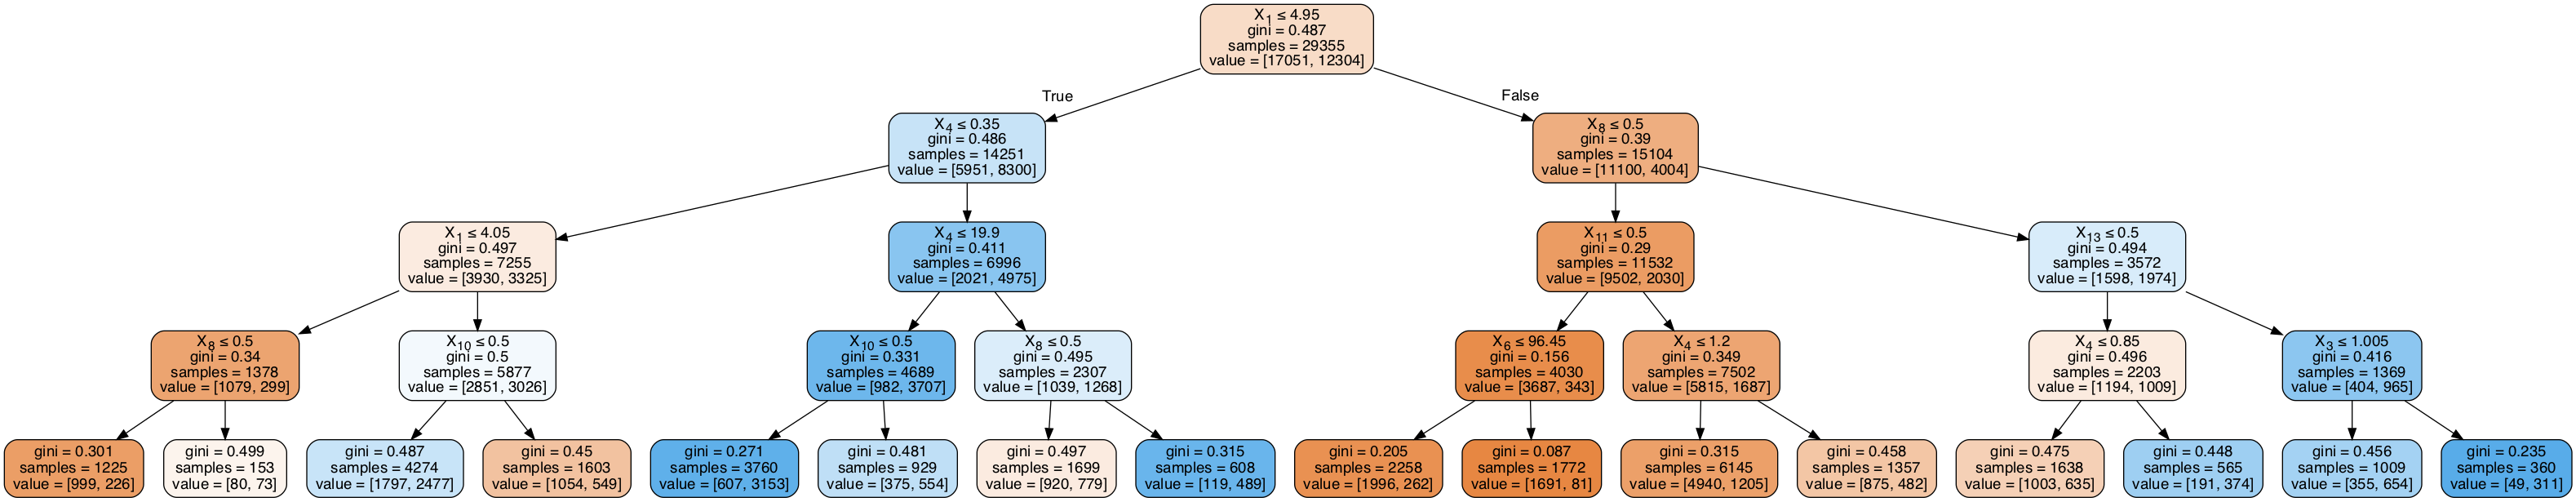

In [288]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(final_clf, out_file=dot_data,max_depth=4,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  

graph.write_pdf("tree.pdf")

Image(graph.create_png())


We now have a model that is about 74% accurate and does a fairly good job of determining the difference between a retained and not retained user as shown by the confusion matrix. In addition, we may have increased accuracy by allowing the tree to grow further, but this reduces interpretability significantly. Looking at the tree, we see we have the most predictive features near the top of the tree. We can quantify how important these features are:



In [289]:
# Find feature importances
feature_importance = pd.DataFrame(final_clf.feature_importances_).T
feature_importance.columns = list(train.columns)
feature_importance


,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True
0,0.0,0.44174,0.0,0.006514,0.19895,0.0,0.00259,0.0,0.238426,0.0,0.057618,0.027014,0.0,0.027147


Again, we see the most predictive features are near the top of the visualized tree as we expected. The top 3 most predictive features, from most to least, are avg_rating_by_driver, city_King's_Landing, and surge_pct.

In terms of model validity, this model is somewhat valid. I don't believe this data is appropriate for the task at hand since we have data for all 6-7 months of user activity and the resulting retention label. If we really want to find early predictors of retention, we should have had user activity up to January, no data for 6 months, and then apply retention labels to build a model to determine whether a user may still be riding with Ultimate after 6 months. This model may be good for determining whether a user is retained, but, since we already have all the data, we essentially know whether a user is retained as of right now by looking at the last date of activity.

